<h1>
<hr style=" border:none; height:3px;">
<center>Computer Vision - Detecting chess boards</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Louis LHOTTE | Paul-Alexandre MARENGHI</center></h4>

# 0 - Imports & datasets

In [5]:
import pandas as pd
import numpy as np
import torch
import kagglehub
import os
import matplotlib.pyplot as plt
import cv2

In [4]:
path = kagglehub.dataset_download("s4lman/chess-pieces-dataset-85x85")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Louis\.cache\kagglehub\datasets\s4lman\chess-pieces-dataset-85x85\versions\2


['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']


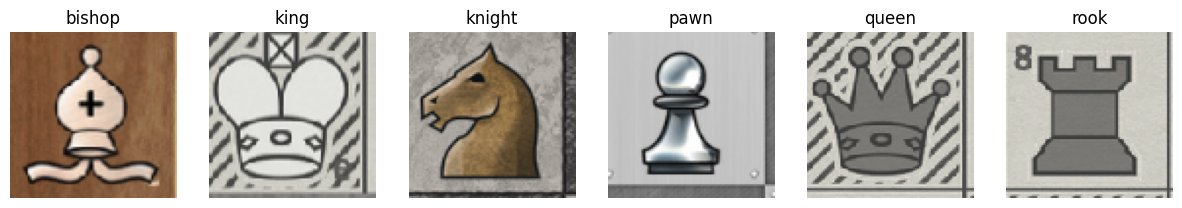

In [ ]:
dataset_path = path + '/data/'
if os.path.exists(dataset_path):
    categories = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    print(categories)
    fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))
    if len(categories) == 1:
        axes = [axes]
    for ax, category in zip(axes, categories):
        category_path = os.path.join(dataset_path, category)
        images = [img for img in os.listdir(category_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        
        if images:
            img_path = os.path.join(category_path, images[0])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ax.imshow(img)
            ax.set_title(category)
            ax.axis("off")

    plt.show()
else:
    print("Dataset path does not exist. Please ensure the dataset is downloaded correctly.")

# I - Chess pieces

# II - Board Detection

In [37]:
import cv2
import numpy as np

def load_image(path):
    img = cv2.imread(path)
    return img

def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def find_chessboard_corners(gray, pattern_size=(7, 7)):
    # Use more robust detection method
    flags = cv2.CALIB_CB_NORMALIZE_IMAGE | cv2.CALIB_CB_EXHAUSTIVE | cv2.CALIB_CB_ACCURACY
    
    ret, corners = cv2.findChessboardCornersSB(gray, pattern_size, flags)
    
    if not ret or corners is None:
        print("❌ Chessboard corners not found (SB method).")
        return None

    # Reshape and return
    return corners.reshape(pattern_size[1], pattern_size[0], 2)

def estimate_outer_corners(corners_grid):
    print(corners_grid)
    top_left = corners_grid[0, 0] - (corners_grid[1, 0] - corners_grid[0, 0])
    top_right = corners_grid[0, -1] + (corners_grid[0, -1] - corners_grid[0, -2])
    bottom_left = corners_grid[-1, 0] - (corners_grid[-2, 0] - corners_grid[-1, 0])
    bottom_right = corners_grid[-1, -1] + (corners_grid[-1, -1] - corners_grid[-1, -2])
    return np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

def warp_chessboard(img, pts_src, board_size=400):
    pts_dst = np.array([[0, 0],
                        [board_size, 0],
                        [board_size, board_size],
                        [0, board_size]], dtype='float32')
    M = cv2.getPerspectiveTransform(pts_src, pts_dst)
    return cv2.warpPerspective(img, M, (board_size, board_size))

def split_into_squares(board_img, grid_size=8):
    board_size = board_img.shape[0]
    square_size = board_size // grid_size
    squares = []
    for i in range(grid_size):
        row = []
        for j in range(grid_size):
            square = board_img[i * square_size:(i + 1) * square_size,
                                j * square_size:(j + 1) * square_size]
            row.append(square)
        squares.append(row)
    return squares

def display_squares(squares, delay=300):
    for i, row in enumerate(squares):
        for j, square in enumerate(row):
            cv2.imshow(f'Square [{i}, {j}]', square)
            cv2.waitKey(delay)
            cv2.destroyWindow(f'Square [{i}, {j}]')

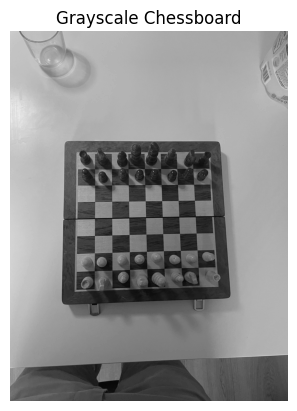

In [42]:
PATH = './data/chessboard/chessboard_7.jpg'
img = load_image(PATH)
gray = convert_to_gray(img)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Chessboard')
plt.axis('off')
plt.show()

In [43]:
corners_grid = find_chessboard_corners(gray)
print(corners_grid)

❌ Chessboard corners not found (SB method).
None


In [ ]:
pts_src = estimate_outer_corners(corners_grid)
warped = warp_chessboard(img, pts_src)
squares = split_into_squares(warped)
display_squares(squares)
print("Chessboard squares detected and processed.")

# III - Move detection

# IV - Conclusion & Next Steps